<a href="https://colab.research.google.com/github/joshualewin6/Colab-Notebook/blob/main/JoshLewiU6proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Brightness of Stars

##Intro

We're going to determine the absolute magnitude (how big it would seem viewed from 10 parsecs, more negative is bigger) of stars based on their radii, temperatures, star categories, and stellar classes (not luminosity since absolute magnitude are very similar, almost measures of the same thing). My dataset doesn't have mass, but we ideally have enough in these four variables that we can build a very good model anyway. We're going to use bambi for this, since normal distributions should be good given that stars' data is typically centered around the main sequence stars. Let's start by importing our libraries.

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-yd_1snmi
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-yd_1snmi
  Resolved https://github.com/pydata/xarray.git to commit 326dbe78d7ea887c2c242e811b7973661137617f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.2.dev31+g326dbe78-py3-none-any.whl size=1247997 sha256=be5797da00dc84caf6c5aee4f0330e041e1abe5202f2d9adb8951c5847c086da
  Stored in directory: /tmp/pip-ephem-wheel-cache-pw0yw45w/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.1
    Uninstalling xarray-2025.1.1:
      Successfully uninstalled xarray-2025.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.0 MB/s eta 0:00:00
   ━

##Data and Predictors
We have a csv with the data we need, so let's import it.

In [ ]:
stars=pd.read_csv('https://raw.githubusercontent.com/YBIFoundation/Dataset/refs/heads/main/Stars.csv')
stars

,Temperature (K),Luminosity (L/Lo),Radius (R/Ro),Absolute magnitude (Mv),Star type,Star category,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,0,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,0,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,0,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,0,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,5,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,5,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,5,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,5,Hypergiant,White,A


We also have to figure out a DAG, so let's start be listing our five variables that we're using.

Absolute Magnitude (predicted)

Temperature, Radius, Star Category, and Spectral Class (probably predictors)

All of these things affect Absolute Magnitude: if a star's hotter it burns brighter; if it's larger there's more spots light can come out, spectral class is based in atomic interactions and emission spectra, so the kind of light coming out should affect the brightness, and the category will also have an effect since it's based on how far stars deviate from the main sequence. So far we have

In [ ]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

mm("""
graph LR;
    Temp--> MV;
    Rad--> MV;
    Cat--> MV;
    Class--> MV;
""")

Temp affects radius, since if it's hotter it pushes itself outward, as does category, since main sequence star sizes widely vary, but giants are always huge, and dwarves are always miniscule. Stellar class effects temp, since the type of atomic interaction will affect temp, with the formation of heavy metals leading to cooler stars, and more hydrogen fusion leading to higher temps, and temp likewise affects molecular interactions (higher temps, hiigher energy interactions). There are also weak interactions based on the above principles: Class --> Rad; Cat --> Temp; and Cat <--> Class. Let's add those interactions.

In [ ]:
mm("""
graph LR;
    Temp--> MV;
    Rad--> MV;
    Cat--> MV;
    Class--> MV;
    Temp--> Rad;
    Cat--> Rad;
    Class--> Temp;
    Class-..-> Cat;
    Class-..-> Rad;
    Cat-..-> Temp;
    Cat-..-> Class;
""")

There's one connection we're missing, though, Star Category is best defined by distinguishing regions on a graph of Star Class and how bright they would appear(luminosity), meaning there is at least a weak three way interaction between Class, Cat, and MV. Let's add that.

In [ ]:
mm("""
graph LR;
    Temp--> MV;
    Rad--> MV;
    Cat--> MV;
    Class--> MV;
    Temp--> Rad;
    Cat--> Rad;
    Class--> Temp;
    Class-..-> Cat;
    Class-..-> Rad;
    Cat-..-> Temp;
    Cat-..-> Class;
    MV--> Class-interact-MV;
    Class--> Class-interact-MV;
    Class-interact-MV-..-> Cat;
""")

Now our graph is cyclic, since MV, through an interaction, affects Category. The way to solve this is simply not using Category as a predictor, so let's modify our DAG to reflect this.

In [ ]:
mm("""
graph LR;
    Temp--> MV;
    Rad--> MV;
    Class--> MV;
    Temp--> Rad;
    Class--> Temp;
    Class-..-> Rad;
""")

At last, we have a beautifully simple DAG, far better than the previous hellish nightmare we had before removing star category.

##The likelihood
Since Absolute Magnitude has values centered around 0, the normal bambi mode seems great. We just need to figure out out priors and interactions.

##The model
We'll try with no interactions, all three interacting, using class as a hierachical category, both with an interaction and not, and finally, class interacting with temp and temp with radius. We'll compare the elpd_loos of these models to see which fits best with out data.

For the first one here, we'll just make sure everything is working properly by having no interactions

In [ ]:
model_plain = bmb.Model("`Absolute magnitude (Mv)` ~ `Temperature (K)` + `Radius (R/Ro)` + `Spectral Class`", data=stars)
idata_plain = model_plain.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [ ]:
model_plain

       Formula: `Absolute magnitude (Mv)` ~ `Temperature (K)` + `Radius (R/Ro)` + `Spectral Class`
        Family: gaussian
          Link: mu = identity
  Observations: 240
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 4.3824, sigma: 51.4072)
            Temperature (K) ~ Normal(mu: 0.0, sigma: 0.0028)
            Radius (R/Ro) ~ Normal(mu: 0.0, sigma: 0.0509)
            Spectral Class ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [ 66.757  102.4235 407.9224 168.3034
                52.7012  70.5069])
        
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 10.5105)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Temperature (K)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

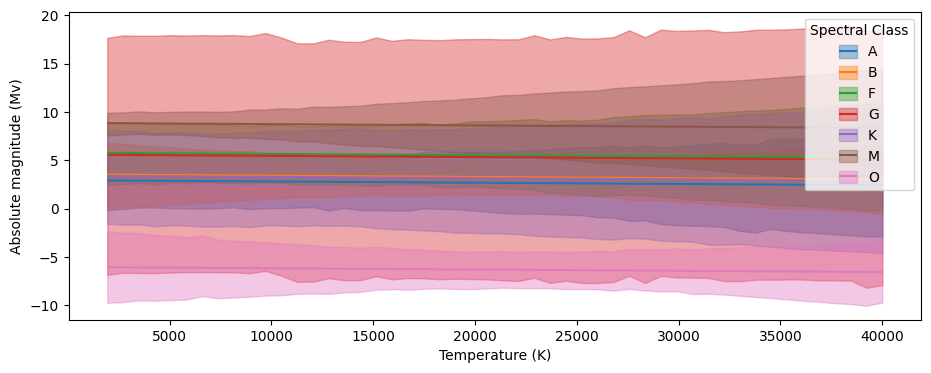

In [ ]:
bmb.interpret.plot_predictions(model_plain,
                               idata_plain,
                                ["Temperature (K)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Radius (R/Ro)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

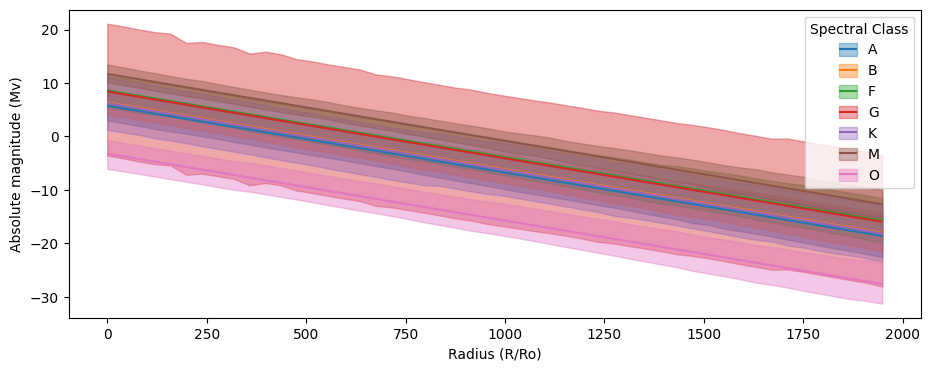

In [ ]:
bmb.interpret.plot_predictions(model_plain,
                               idata_plain,
                                ["Radius (R/Ro)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

<Axes: xlabel='Absolute magnitude (Mv)'>

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


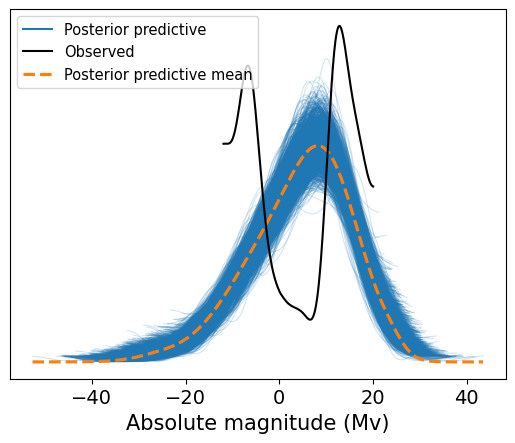

In [ ]:
model_plain.predict(idata_plain, kind="response")
az.plot_ppc(idata_plain)

So, as you can see, the resulting graphs are pretty believable, and radius and spectral class seem to be very strong predictors right off rip. However, the ppc is ... interesting. I can't think of a likelihood that looks anything remotely like this, and since it' roughly centered around 0 and is kind of symmetrical, we'll leave it normal (especially considering the data is a little sketchy, so my posterior is probably much closer to reality than the data itself). Let's briefly try changing the priors for radius and temp to exponential and see if that helps, since it reflects reality a bit more.

In [ ]:
priors ={"Temperature (K)" : bmb.Prior("Exponential", lam=1/10000), "Radius (R/Ro)" : bmb.Prior("Exponential",lam=1/200)}
model_exp = bmb.Model("`Absolute magnitude (Mv)` ~ `Temperature (K)` + `Radius (R/Ro)` + `Spectral Class`", data=stars, family="exponential",priors=priors)
model_exp

       Formula: `Absolute magnitude (Mv)` ~ `Temperature (K)` + `Radius (R/Ro)` + `Spectral Class`
        Family: exponential
          Link: mu = log
  Observations: 240
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 3.8759)
            Temperature (K) ~ Exponential(lam: 0.0001)
            Radius (R/Ro) ~ Exponential(lam: 0.005)
            Spectral Class ~ Normal(mu: [0. 0. 0. 0. 0. 0.], sigma: [ 6.3514  9.7448 38.8108 16.0128  5.0141
                6.7082])

In [ ]:
idata_exp = model_exp.fit(idata_kwargs={'log_likelihood': True})

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'Intercept': array(-0.06147709), 'Temperature (K)_log__': array(8.62217148), 'Radius (R/Ro)_log__': array(5.76200857), 'Spectral Class': array([ 0.57452911, -0.21089821, -0.53821297,  0.60754442,  0.97738754,
        0.81434579])}

Logp initial evaluation results:
{'Intercept': -2.27, 'Temperature (K)': -1.14, 'Radius (R/Ro)': -1.13, 'Spectral Class': -19.62, 'Absolute magnitude (Mv)': -inf}
You can call `model.debug()` for more details.

Okay, fat nope, we just get errors, we'll stick with bambi's normals. Now let's build the rest of the models. We'll also do three that exclude temp since it seems so much weaker than radius and class.

In [ ]:
model_allint = bmb.Model("`Absolute magnitude (Mv)` ~ `Temperature (K)` + `Radius (R/Ro)` + `Spectral Class` + `Temperature (K)`:`Radius (R/Ro)` + `Radius (R/Ro)`:`Spectral Class` + `Temperature (K)`:`Spectral Class`", data=stars)
idata_allint = model_allint.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Temperature (K)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

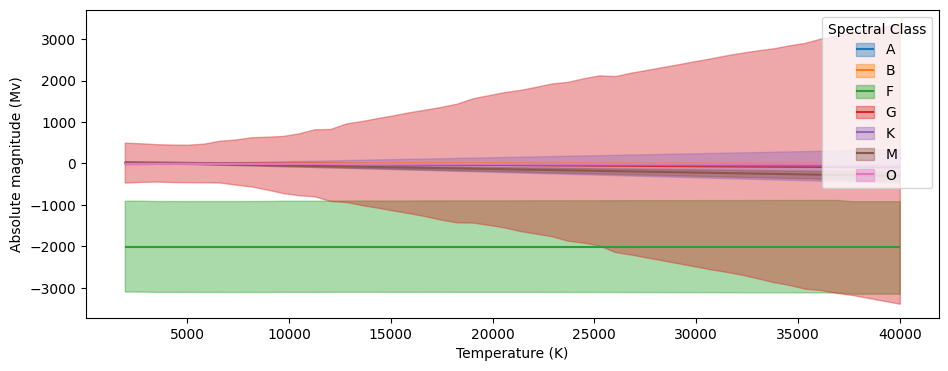

In [ ]:
bmb.interpret.plot_predictions(model_allint,
                               idata_allint,
                                ["Temperature (K)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Radius (R/Ro)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

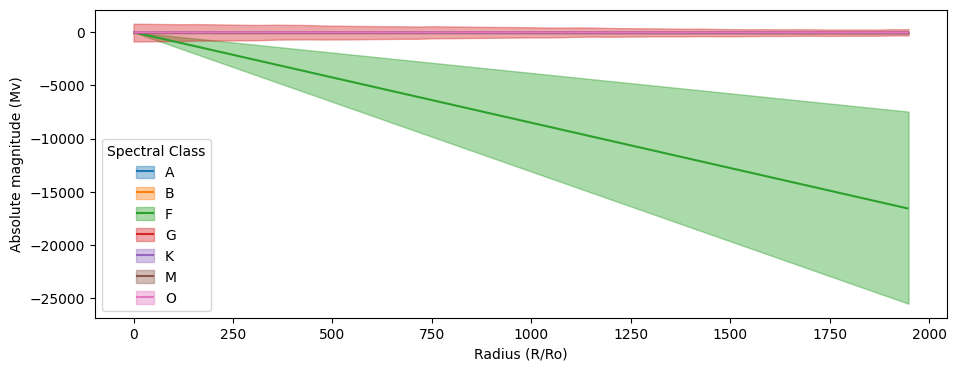

In [ ]:
bmb.interpret.plot_predictions(model_allint,
                               idata_allint,
                                ["Radius (R/Ro)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

In [ ]:
model_h = bmb.Model("`Absolute magnitude (Mv)` ~ (`Temperature (K)` + `Radius (R/Ro)` | `Spectral Class`)", data=stars)
idata_h = model_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Temperature (K)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

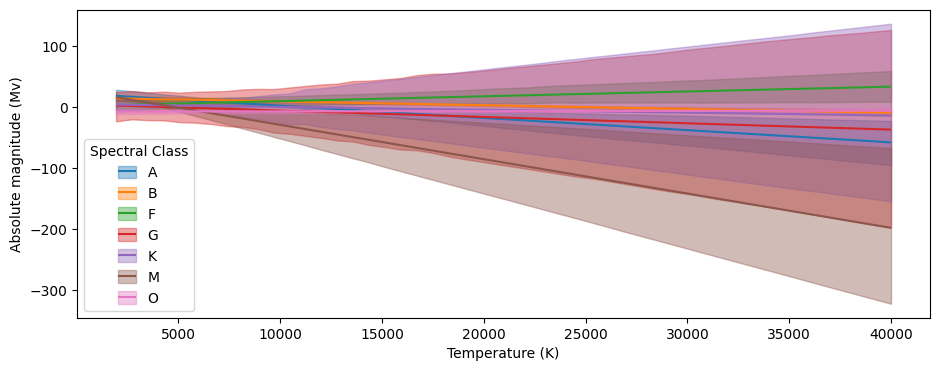

In [ ]:
bmb.interpret.plot_predictions(model_h,
                               idata_h,
                                ["Temperature (K)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Radius (R/Ro)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

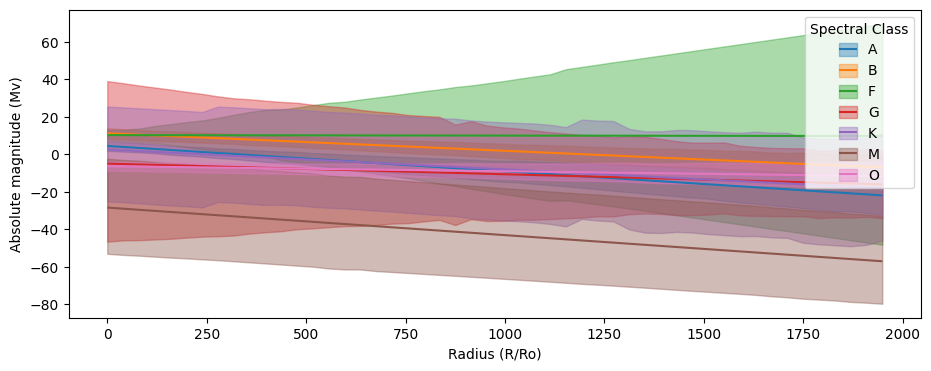

In [ ]:
bmb.interpret.plot_predictions(model_h,
                               idata_h,
                                ["Radius (R/Ro)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

In [ ]:
model_hint = bmb.Model("`Absolute magnitude (Mv)` ~ (`Temperature (K)` + `Radius (R/Ro)` + `Temperature (K)`:`Radius (R/Ro)` | `Spectral Class`)", data=stars)
idata_hint = model_hint.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 44 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Temperature (K)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

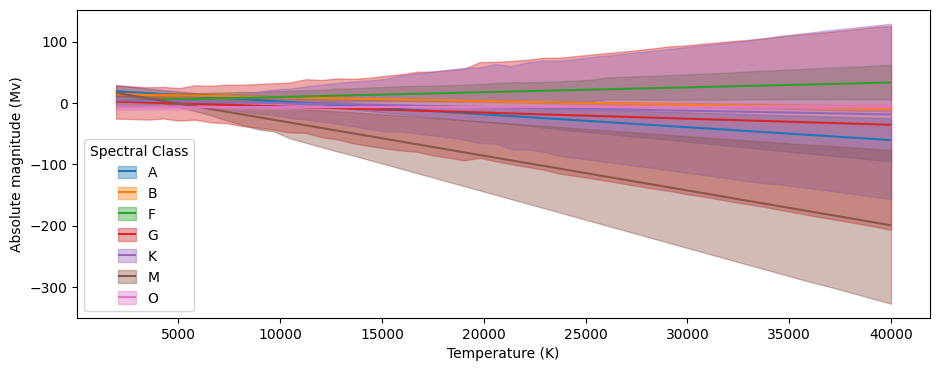

In [ ]:
bmb.interpret.plot_predictions(model_hint,
                               idata_hint,
                                ["Temperature (K)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Radius (R/Ro)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

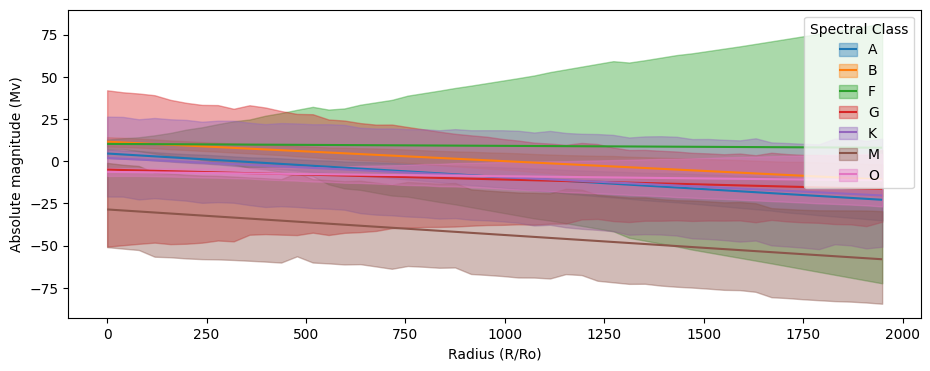

In [ ]:
bmb.interpret.plot_predictions(model_hint,
                               idata_hint,
                                ["Radius (R/Ro)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

In [ ]:
model_twoint = bmb.Model("`Absolute magnitude (Mv)` ~ `Temperature (K)` + `Radius (R/Ro)` + `Spectral Class` + `Temperature (K)`:`Radius (R/Ro)` + `Temperature (K)`:`Spectral Class`", data=stars)
idata_twoint = model_twoint.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Temperature (K)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

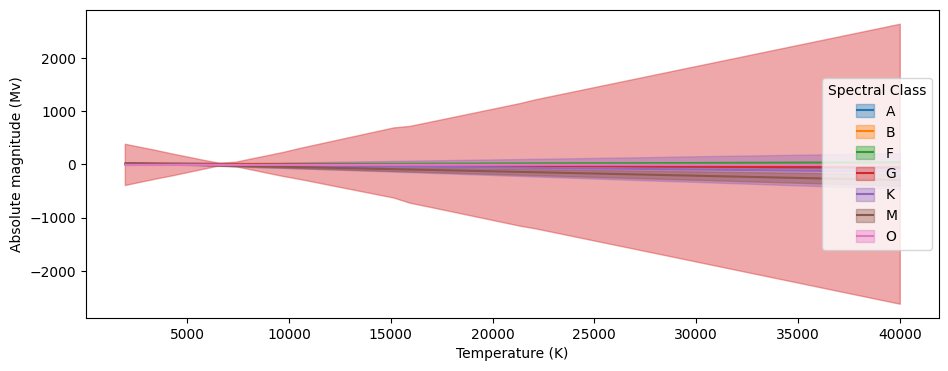

In [ ]:
bmb.interpret.plot_predictions(model_twoint,
                               idata_twoint,
                                ["Temperature (K)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Radius (R/Ro)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

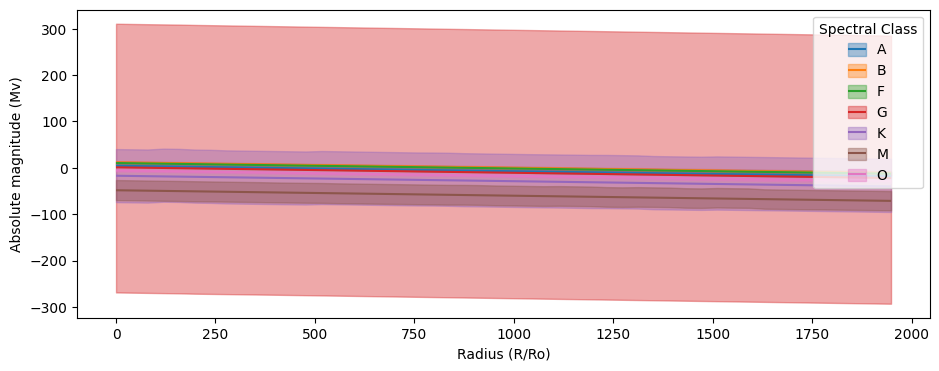

In [ ]:
bmb.interpret.plot_predictions(model_twoint,
                               idata_twoint,
                                ["Radius (R/Ro)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

In [ ]:
model_notemp = bmb.Model("`Absolute magnitude (Mv)` ~ `Radius (R/Ro)` + `Spectral Class`", data=stars)
idata_notemp = model_notemp.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Radius (R/Ro)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

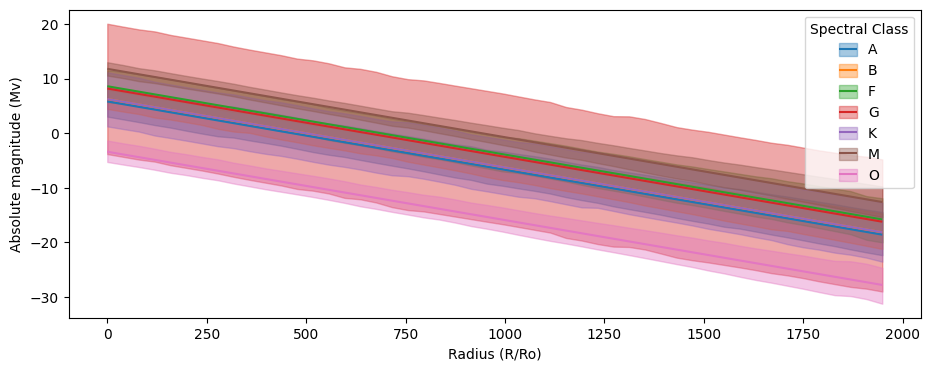

In [ ]:
bmb.interpret.plot_predictions(model_notemp,
                               idata_notemp,
                                ["Radius (R/Ro)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

In [ ]:
model_notempint = bmb.Model("`Absolute magnitude (Mv)` ~ `Radius (R/Ro)` + `Spectral Class` + `Radius (R/Ro)`:`Spectral Class`", data=stars)
idata_notempint = model_notempint.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Radius (R/Ro)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

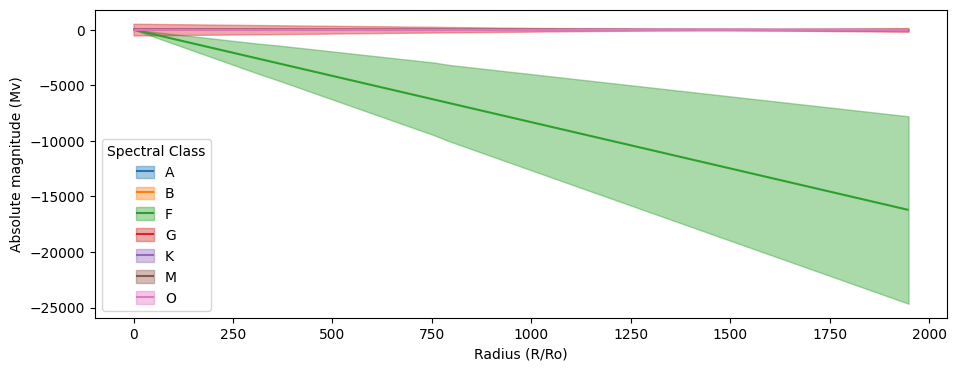

In [ ]:
bmb.interpret.plot_predictions(model_notempint,
                               idata_notempint,
                                ["Radius (R/Ro)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

In [ ]:
model_notemph = bmb.Model("`Absolute magnitude (Mv)` ~ (`Radius (R/Ro)`|`Spectral Class`)", data=stars)
idata_notemph = model_notemph.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


(<Figure size 1100x400 with 1 Axes>,
 array([<Axes: xlabel='Radius (R/Ro)', ylabel='Absolute magnitude (Mv)'>],
       dtype=object))

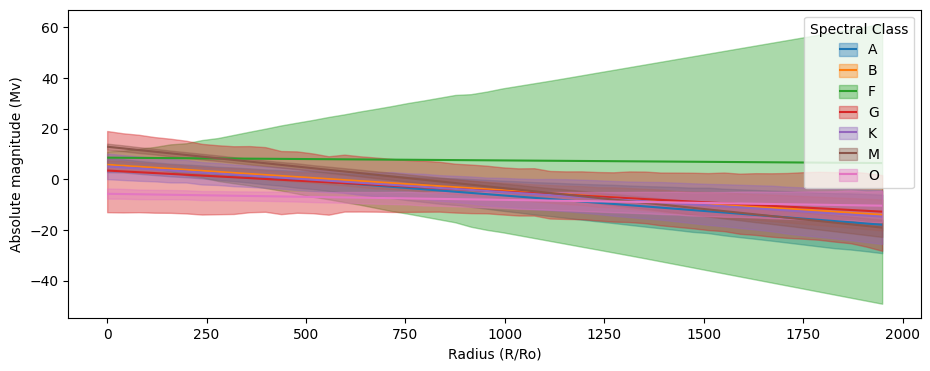

In [ ]:
bmb.interpret.plot_predictions(model_notemph,
                               idata_notemph,
                                ["Radius (R/Ro)",  "Spectral Class"], fig_kwargs={"figsize":(11, 4)})

##Comparing the Models

Now all we need to do is compare the elpd_loos to see which of these models is the best, so let's take a look.

In [ ]:
cmp_df = az.compare( {"plain":idata_plain,"all_interacting":idata_allint,"hierarchy":idata_h,"hierarchy_interacting":idata_hint,"two_interacting":idata_twoint,"no_temperature":idata_notemp,"no_temperature_interacting":idata_notempint,"no_temperature_hierarchy":idata_notemph} )
cmp_df

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
all_interacting,0,-739.897339,13.604666,0.000000,9.390931e-01,17.127601,0.000000,True,log
two_interacting,1,-743.469402,11.371646,3.572063,1.669903e-12,16.575578,2.490880,True,log
hierarchy_interacting,2,-746.572007,12.691238,6.674669,1.847773e-12,16.829785,2.991188,True,log
hierarchy,3,-748.035683,13.091341,8.138344,1.936076e-12,16.758738,3.149398,True,log
no_temperature_interacting,4,-768.007577,9.205083,28.110238,1.520672e-12,15.838204,8.117951,True,log
no_temperature_hierarchy,5,-774.021976,9.047303,34.124637,1.792136e-12,14.930722,8.247332,True,log
no_temperature,6,-794.176793,8.126997,54.279454,6.090691e-02,12.624934,11.053410,True,log
plain,7,-795.061404,8.983262,55.164065,0.000000e+00,12.655820,11.158277,True,log


Ok, so looking at this, everything interacting is the clear favorite, however, everything interacting is clearly a horrible model. The F-class stars (middle of the pack stars) are given far lower magnitudes than anything remotely possible, so I'm going to remove that and recompare.

In [ ]:
cmp_df_no_all = az.compare( {"plain":idata_plain,"hierarchy":idata_h,"hierarchy_interacting":idata_hint,"two_interacting":idata_twoint,"no_temperature":idata_notemp,"no_temperature_interacting":idata_notempint,"no_temperature_hierarchy":idata_notemph} )
cmp_df_no_all

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
two_interacting,0,-743.469402,11.371646,0.000000,9.090627e-01,16.575578,0.000000,True,log
hierarchy_interacting,1,-746.572007,12.691238,3.102606,3.704889e-13,16.829785,2.078790,True,log
hierarchy,2,-748.035683,13.091341,4.566281,3.997011e-13,16.758738,2.327727,True,log
no_temperature_interacting,3,-768.007577,9.205083,24.538175,5.442110e-02,15.838204,8.159323,True,log
no_temperature_hierarchy,4,-774.021976,9.047303,30.552574,4.660312e-13,14.930722,7.789267,True,log
no_temperature,5,-794.176793,8.126997,50.707391,3.651623e-02,12.624934,10.587772,True,log
plain,6,-795.061404,8.983262,51.592002,0.000000e+00,12.655820,10.693737,True,log


Ok, there's still nothing good coming of this, two interactions is not a good predictive model, even if its ppc is alright. There is, however, a possible remedy.

##Return of the category
Category, as you may recall, is mildly dependent on absolute magnitude, however, the interaction is weak enough that it may be possibe to ignore it and use category to create a decent model, especially considering that the data seems cherrypicked to include roughly even amounts of each star category. Let's start with a new DAG using what we now know about temp and our possible use of category.

In [ ]:
mm("""
graph LR;
    Temp-..-> MV;
    Rad--> MV;
    Cat--> MV;
    Class--> MV;
    Temp-..-> Rad;
    Cat--> Rad;
    Class--> Temp;
    Class-..-> Cat;
    Class-..-> Rad;
    Cat-..-> Temp;
    Cat-..-> Class;
""")

Let's try 4 more, 2 with temp, 2 without, 2 with interactions, 2 without. I'm not graphing them since there's too many variables, but I'll plot the one with the highest elpd_loo

In [ ]:
model_cattempint = bmb.Model("`Absolute magnitude (Mv)` ~ `Temperature (K)` + `Radius (R/Ro)` + `Spectral Class` + `Star category` + `Star category`:`Radius (R/Ro)` + `Temperature (K)`:`Spectral Class`", data=stars)
idata_cattempint = model_cattempint.fit(idata_kwargs={'log_likelihood': True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:05:41

In [ ]:
model_cattemp = bmb.Model("`Absolute magnitude (Mv)` ~ `Temperature (K)` + `Radius (R/Ro)` + `Spectral Class` + `Star category`", data=stars)
idata_cattemp = model_cattemp.fit(idata_kwargs={'log_likelihood': True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:15

In [ ]:
model_catint = bmb.Model("`Absolute magnitude (Mv)` ~ `Radius (R/Ro)` + `Spectral Class` + `Star category` + `Star category`:`Radius (R/Ro)`", data=stars)
idata_catint = model_catint.fit(idata_kwargs={'log_likelihood': True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:04:29

In [ ]:
model_cat = bmb.Model("`Absolute magnitude (Mv)` ~ `Radius (R/Ro)` + `Spectral Class` + `Star category`", data=stars)
idata_cat = model_cat.fit(idata_kwargs={'log_likelihood': True})

Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:13

In [40]:
cmp_df_cat = az.compare( {"cat_temp_interactions":idata_cattempint,"cat_temp":idata_cattemp,"cat_interaction":idata_catint,"just_cat":idata_cat} )
cmp_df_cat

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
cat_temp_interactions,0,-410.005018,27.315810,0.000000,6.603046e-01,12.020306,0.000000,True,log
cat_interaction,1,-410.313029,19.775732,0.308012,3.396954e-01,10.580759,5.291626,True,log
cat_temp,2,-452.164228,21.752123,42.159210,8.992787e-14,15.455924,10.979280,True,log
just_cat,3,-456.043761,21.559087,46.038743,2.046474e-12,15.287313,11.115274,True,log


Nope, these all also have warnings and aren't feasibly good models and predictors for Absolute Magnitude.

##Conclusion

Well, you can't win 'em all. None of my models have come even close to being good. I think it ultimately has something to do with my inability to make exponential priors work, since really that's how radius and temp should be treated. However, I still think a good model could be created that could predict these well, but I'd want to use pymc rather than bambi and make those exponentials work.